In [1]:
import pandas as pd

# 데이터 세트 호출
m_df = pd.read_csv('./datasets/medical_insurance.csv', low_memory=False)
m_df

age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
2767   47  female  45.320         1     no  southeast   8569.86180
2768   21  female  34.600         0     no  southwest   2020.17700
2769   19    male  26.030         1    yes  northwest  16450.89470
2770   23    male  18.715         0     no  northwest  21595.38229
2771   54    male  31.600         0     no  southwest   9850.43200

[2772 rows x 7 columns]

#### 📊 데이터 전처리

In [2]:
# 중복행 제거
pre_m_df = m_df.drop_duplicates().reset_index(drop=True)

In [3]:
# 타겟 데이터 이상치 제거
from sklearn.preprocessing import StandardScaler

# 표준화 객체 생성
std = StandardScaler()
# 데이터 표준화 변환
result = std.fit_transform(pre_m_df[['charges']])
# 표준화 데이터 프레임 생성
std_pre_m_df = pd.DataFrame(result, columns=['charges'])

# 타겟 데이터 이상치 제거
std_pre_m_df = std_pre_m_df[std_pre_m_df.charges.between(-1.96, 1.96)]

# 이상치 제거후 유지되는 인덱스를 대조하여 원본 데이터 이상치 제거
pre_m_df = pre_m_df.iloc[std_pre_m_df.index].reset_index(drop=True)

In [4]:
# 타겟 컬럼 분포 변환
from sklearn.preprocessing import PowerTransformer

ptf = PowerTransformer(standardize=False)
pre_m_df['charges'] = ptf.fit_transform(pre_m_df[['charges']])

In [5]:
from sklearn.preprocessing import LabelEncoder

# 데이터 프레임 복제
enc_m_df = pre_m_df.copy()
encoders = {}

# 문자열 컬럼 추출
columns = ['sex', 'smoker']

# 반복하여 컬럼 인코딩 처리:
for column in columns:
    # 레이블인코더 객체 생성
    encoder = LabelEncoder()
    # 문자열 데이터 정수로 형변환
    result = encoder.fit_transform(enc_m_df[column])
    # 형변환 값으로 대체
    enc_m_df[column] = result
    # 원본 데이터 담기
    encoders[column] = encoder.classes_

In [6]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 원 핫 인코더 객체 생성
# sparse_output: False = 밀집행렬(실제 값으로 채워진 행렬) 반환
one_hot_encoder = OneHotEncoder(sparse_output=False)
# 지역 피처 인코딩 처리
result = one_hot_encoder.fit_transform(enc_m_df[['region']])

# 인코딩 값 데이터 프레임으로 생성하고 정수로 형변환한 뒤, 기존 데이터 프레임과 병합
enc_m_df = pd.concat([enc_m_df, pd.DataFrame(result, columns=one_hot_encoder.categories_).astype(np.int8)], axis=1)

# 사용이 끝난 데이터 제거
enc_m_df = enc_m_df.drop(labels='region', axis=1)

# 원 핫 인코딩 컬럼명 변경
enc_m_df.rename(columns={
    ('northeast',): 'northeast',
    ('northwest',): 'northwest',
    ('southeast',): 'southeast',
    ('southwest',): 'southwest',
}, inplace=True)

In [7]:
# 타겟 컬럼 위치 변경을 위해 새로운 컬럼에 데이터 담기
enc_m_df['target'] = enc_m_df.charges
# 기존 컬럼은 제거
enc_m_df = enc_m_df.drop(labels='charges', axis=1)

### 🌟 1Cycle

#### 🚩 1Cycle 결과
- 회귀  
**MSE: 2.0043, RMSE: 1.4158, MSLE: 0.0052, RMSLE: 0.0720, R2: 0.7340**

- 다중 회귀  
**MSE: 2.2306, RMSE: 1.4935, MSLE: 0.0060, RMSLE: 0.0774, R2: 0.7040**

- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 💡 분석
- 회귀 분석 결과 R2 점수가 약 0.76이 나옴에 따라 선형 패턴을 지니고 있다고 보여졌으나,  
  다중 회귀로 곡선을 부여하였을 때 약 R2 점수가 0.82로 상승함에 따라 완전한 선형은 아니고 비선형의 패턴도 띄고 있음을 확인함.
- 회귀 모델 중 GradientBoostingRegressor을 사용하였을 때, 가장 좋은 성능을 보임에 따라 해당 모델을 선택하는 것이 적합하다고 판단됨.

### 🌟 2Cycle

In [8]:
# 피처 제거
columns = ['northeast', 'northwest', 'southeast', 'southwest', 'sex']

enc_m_df = enc_m_df.drop(columns=columns, axis=1)

#### 🚩 1Cycle 결과
- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322**

#### 💡 분석
- 상관관계가 낮은 피처 제거 후 성능이 매우 근소한 차이로 저하된 것을 확인하였지만, 다중 공산성을 해결하기 위해 제거하기로 함.
- validation 분리 후 훈련하여 성능평가를 재진행하기로 함.

### 🌟 3Cycle

#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322**
  
#### 🚩 3Cycle 결과
- Validation (cv)  
**MSE: 1.8219, RMSE: 1.3498, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7583**

- Validation (K-Fold)  
**MSE: 1.8234, RMSE: 1.3503, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7581**

#### 💡 분석
- validation 후 성능이 더 향상된 것으로 나타났으며, 5-폴드보다 k-폴드의 성능이 근소한 차이로 열세한 것으로 나타남.
- 차원 축소 시 성능이 어떻게 조정되는지 확인하기로 함.

### 🌟 4Cycle

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
         .format(MSE, RMSE, MSLE, RMSLE, R2))

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 문제/정답 및 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 파이프라인 구축
# 정규화, 차원축소, 모델
pipe = Pipeline([('pca', PCA(n_components=3)), ('gb_r', GradientBoostingRegressor(random_state=124))])

# 파라미터 값 조정
parameters = {'gb_r__max_depth': [3, 4, 5], 'gb_r__min_samples_split': [50, 60, 70], 'gb_r__n_estimators': [40, 50, 60]}

# 훈련 및 교차검증 모델 설정
grid_pipe = GridSearchCV(pipe, param_grid=parameters, cv=5, n_jobs=-1)

# 훈련
grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=3)),
                                       ('gb_r',
                                        GradientBoostingRegressor(random_state=124))]),
             n_jobs=-1,
             param_grid={'gb_r__max_depth': [3, 4, 5],
                         'gb_r__min_samples_split': [50, 60, 70],
                         'gb_r__n_estimators': [40, 50, 60]})

In [11]:
# 훈련 결과 확인
result_df = pd.DataFrame(grid_pipe.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

params  mean_test_score  \
0   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.316967   
1   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.318121   
2   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.315413   
3   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.322344   
4   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.323007   
5   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.321908   
6   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.315417   
7   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.316003   
8   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.315303   
9   {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.319725   
10  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.321336   
11  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.317297   
12  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.312973   
13  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.309047   
14  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.313988   
15  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.318352   
16  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.322196   
17  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.317589   
18  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.320396   
19  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.320252   
20  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.311115   
21  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.314868   
22  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.312793   
23  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.310820   
24  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.312826   
25  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.316026   
26  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.314801   

    rank_test_score  
0                13  
1                10  
2                17  
3                 2  
4                 1  
5                 4  
6                16  
7                15  
8                18  
9                 8  
10                5  
11               12  
12               22  
13               27  
14               21  
15                9  
16                3  
17               11  
18                6  
19                7  
20               25  
21               19  
22               24  
23               26  
24               23  
25               14  
26               20

In [12]:
# 최적의 파라미터 값 담기
pac_gb_r = grid_pipe.best_estimator_

# 예측
prediction = pac_gb_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 4.9929, RMSE: 2.2345, MSLE: 0.0133, RMSLE: 0.1154, R2: 0.3375


#### 🚩 3Cycle 결과
- Validation (cv)  
**MSE: 1.8219, RMSE: 1.3498, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7583**

#### 🚩 4Cycle 결과
- 차원축소 (3차원)  
**MSE: 4.9929, RMSE: 2.2345, MSLE: 0.0133, RMSLE: 0.1154, R2: 0.3375**

#### 💡 분석
- 차원 축소 시 성능이 훨씬 저하된다는 것을 확인함.
- 정규화 추가 진행 후 성능이 어떻게 변화하는지 더 확인해 보기로 함.

### 🌟 5Cycle

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 문제/정답 및 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 파이프라인 구축
# 정규화, 차원축소, 모델
pipe = Pipeline([('std', StandardScaler()), ('pca', PCA(n_components=3)), ('gb_r', GradientBoostingRegressor(random_state=124))])

# 파라미터 값 조정
parameters = {'gb_r__max_depth': [3, 4, 5], 'gb_r__min_samples_split': [50, 60, 70], 'gb_r__n_estimators': [40, 50, 60]}

# 훈련 및 교차검증 모델 설정
grid_pipe = GridSearchCV(pipe, param_grid=parameters, cv=5, n_jobs=-1)

# 훈련
grid_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('pca', PCA(n_components=3)),
                                       ('gb_r',
                                        GradientBoostingRegressor(random_state=124))]),
             n_jobs=-1,
             param_grid={'gb_r__max_depth': [3, 4, 5],
                         'gb_r__min_samples_split': [50, 60, 70],
                         'gb_r__n_estimators': [40, 50, 60]})

In [14]:
# 훈련 결과 확인
result_df = pd.DataFrame(grid_pipe.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

params  mean_test_score  \
0   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.675039   
1   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.676393   
2   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.674064   
3   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.674246   
4   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.675966   
5   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.675506   
6   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.673357   
7   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.675934   
8   {'gb_r__max_depth': 3, 'gb_r__min_samples_spli...         0.675101   
9   {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.674017   
10  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.669308   
11  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.665896   
12  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.677383   
13  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.673432   
14  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.669799   
15  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.676465   
16  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.674708   
17  {'gb_r__max_depth': 4, 'gb_r__min_samples_spli...         0.670144   
18  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.657415   
19  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.652391   
20  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.649002   
21  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.659919   
22  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.656142   
23  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.654009   
24  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.663544   
25  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.659383   
26  {'gb_r__max_depth': 5, 'gb_r__min_samples_spli...         0.654800   

    rank_test_score  
0                 8  
1                 3  
2                11  
3                10  
4                 4  
5                 6  
6                14  
7                 5  
8                 7  
9                12  
10               17  
11               18  
12                1  
13               13  
14               16  
15                2  
16                9  
17               15  
18               22  
19               26  
20               27  
21               20  
22               23  
23               25  
24               19  
25               21  
26               24

In [15]:
# 최적의 파라미터 값 담기
pac_gb_r = grid_pipe.best_estimator_

# 예측
prediction = pac_gb_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 2.1718, RMSE: 1.4737, MSLE: 0.0060, RMSLE: 0.0773, R2: 0.7118


#### 📊 시각화

In [16]:
cycle4_5_data = {
    'model': ['Validation (cv)', '차원축소(4차원)', '정규화 후 차원축소(4차원)'],
    'R2': [0.7583, 0.3375, 0.7118],
}

cycle4_5 = pd.DataFrame(cycle4_5_data)

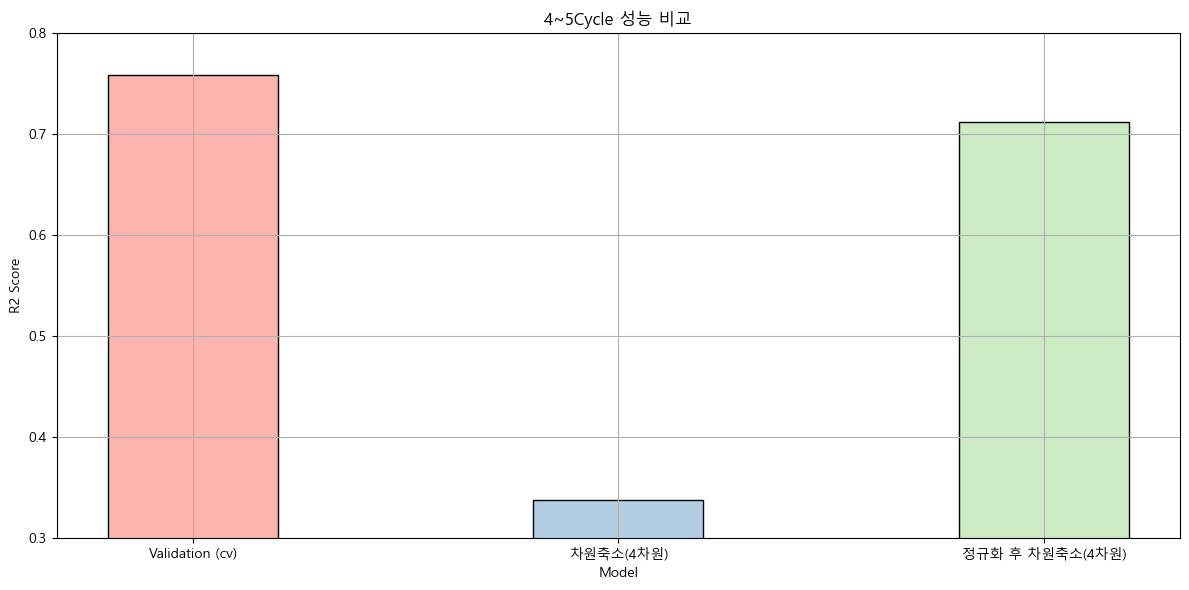

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 경로 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 컬러맵 가져오기
cmap = plt.get_cmap('Pastel1')

plt.bar(cycle4_5['model'], cycle4_5['R2'], color=cmap(np.array([0, 1, 2])), edgecolor='black', width=0.4)
plt.title('4~5Cycle 성능 비교')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.grid(True)

# y축의 범위 지정
plt.ylim(0.3, 0.8)

plt.tight_layout()
plt.show()

#### 🚩 3Cycle 결과
- Validation (cv)  
**MSE: 1.8219, RMSE: 1.3498, MSLE: 0.0048, RMSLE: 0.0694, R2: 0.7583**

#### 🚩 4Cycle 결과
- 차원축소 (3차원)  
**MSE: 4.9929, RMSE: 2.2345, MSLE: 0.0133, RMSLE: 0.1154, R2: 0.3375**

#### 🚩 5Cycle 결과
- 정규화 처리 후 차원축소 (3차원)  
**MSE: 2.1718, RMSE: 1.4737, MSLE: 0.0060, RMSLE: 0.0773, R2: 0.7118**

#### 💡 분석
- 전처리 후 성능이 더 향상은 되었으나, 차원 축소 전 성능이 훨씬 우세하다는 것을 확인함.
- 0.8 이상은 과적합이 우려되기 때문에 규제를 별도로 더 진행하기로 함.